# Physics-Informed Neural Network for Pipe Network Pressure Prediction

This notebook implements a **Physics-Informed Neural Network (PINN)** that predicts pressure distribution across a pipe network by embedding fluid mechanics constraints (Darcy-Weisbach equation and continuity) directly into the loss function.

**Network:** 5-junction, 6-pipe network  
**Physics:** Continuity equation + Darcy-Weisbach pressure-flow relationship  
**Training:** 20,000 epochs, Adam optimizer  
**Qualified:** Smart India Hackathon 2024

## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## 2. Network Configuration

Define pipe network geometry: 5 junctions connected by 6 pipes with randomized physical properties.

In [2]:
np.random.seed(42)
torch.manual_seed(42)

num_junctions = 5
num_pipes = 6

# Physical pipe properties
pipe_lengths    = np.random.uniform(10, 100, num_pipes)   # meters
pipe_diameters  = np.random.uniform(0.1, 1.0, num_pipes)  # meters
friction_factors = np.random.uniform(0.01, 0.05, num_pipes)

# Network topology: [from_node, to_node]
connectivity = np.array([
    [0, 1],
    [1, 2],
    [1, 3],
    [3, 4],
    [2, 4],
    [0, 3],
])

# Boundary conditions
pressure_inlet  = 100.0  # Pa at junction 0
pressure_outlet = 50.0   # Pa at junction 4

# Convert to tensors
pipe_lengths     = torch.tensor(pipe_lengths,     dtype=torch.float32)
pipe_diameters   = torch.tensor(pipe_diameters,   dtype=torch.float32)
friction_factors = torch.tensor(friction_factors, dtype=torch.float32)
connectivity     = torch.tensor(connectivity,     dtype=torch.long)

## 3. PINN Model

A fully-connected network with Tanh activations. Takes a zero input vector and outputs predicted pressure at each junction. Physics constraints are enforced through the loss function, not the architecture.

In [3]:
class PipeNetworkPINN(nn.Module):
    def __init__(self, num_junctions):
        super(PipeNetworkPINN, self).__init__()
        self.fc1 = nn.Linear(num_junctions, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, num_junctions)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PipeNetworkPINN(num_junctions)
print(model)

PipeNetworkPINN(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (activation): Tanh()
)


## 4. Physics-Informed Loss Function

Loss combines two physics constraints:
- **Continuity equation:** Flow in = Flow out at each interior junction
- **Boundary conditions:** Enforce known inlet/outlet pressures

Flow through each pipe is computed via the Darcy-Weisbach equation:
$$Q = v \cdot A, \quad v = \sqrt{\frac{2 \Delta P}{f \cdot L/D}}$$

In [4]:
def loss_fn(pressures_pred, pipe_lengths, pipe_diameters, friction_factors, connectivity):
    """Physics-informed loss: continuity residuals + boundary condition penalties."""
    loss = 0.0
    batch_size = pressures_pred.size(0)

    for b in range(batch_size):
        pressures = pressures_pred[b]

        # Continuity: enforce flow conservation at interior junctions
        for j in range(1, num_junctions - 1):
            incoming_flow = 0.0
            outgoing_flow = 0.0

            for i in range(connectivity.size(0)):
                from_node = connectivity[i, 0]
                to_node   = connectivity[i, 1]
                delta_p   = pressures[from_node] - pressures[to_node]
                delta_p   = torch.clamp(delta_p, min=1e-6)  # numerical stability

                # Darcy-Weisbach velocity
                velocity = torch.sqrt((2 * delta_p) / (friction_factors[i] * (pipe_lengths[i] / pipe_diameters[i])))
                flow = velocity * (np.pi * (pipe_diameters[i] / 2) ** 2)

                if to_node == j:
                    incoming_flow += flow
                elif from_node == j:
                    outgoing_flow += flow

            continuity_residual = incoming_flow - outgoing_flow
            loss += continuity_residual ** 2

        # Boundary condition penalties
        loss += (pressures[0] - pressure_inlet) ** 2
        loss += (pressures[num_junctions - 1] - pressure_outlet) ** 2

    return loss / batch_size

## 5. Training

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20000
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    input_tensor   = torch.zeros((1, num_junctions))
    pressures_pred = model(input_tensor)

    loss = loss_fn(pressures_pred, pipe_lengths, pipe_diameters, friction_factors, connectivity)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch + 1) % 2000 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1:>5}/{epochs}]  Loss: {loss.item():.6f}")

print("\nTraining complete.")

Epoch [    1/20000]  Loss: 12551.110352
Epoch [ 2000/20000]  Loss: 6835.496582
Epoch [ 4000/20000]  Loss: 3506.786133
Epoch [ 6000/20000]  Loss: 1551.387695
Epoch [ 8000/20000]  Loss: 508.532806
Epoch [10000/20000]  Loss: 78.426888
Epoch [12000/20000]  Loss: 1.426286
Epoch [14000/20000]  Loss: 0.005224
Epoch [16000/20000]  Loss: 0.005190
Epoch [18000/20000]  Loss: 0.005187
Epoch [20000/20000]  Loss: 0.005179

Training complete.


## 6. Results

In [6]:
model.eval()
with torch.no_grad():
    pressures_pred = model(torch.zeros((1, num_junctions))).numpy().flatten()

print("Predicted Pressures at Junctions:")
for i, p in enumerate(pressures_pred):
    label = " (inlet)" if i == 0 else " (outlet)" if i == num_junctions - 1 else ""
    print(f"  Junction {i}{label}: {p:.2f} Pa")

Predicted Pressures at Junctions:
  Junction 0 (inlet): 100.00 Pa
  Junction 1: 0.45 Pa
  Junction 2: 0.69 Pa
  Junction 3: 92.81 Pa
  Junction 4 (outlet): 50.00 Pa


## 7. Visualizations

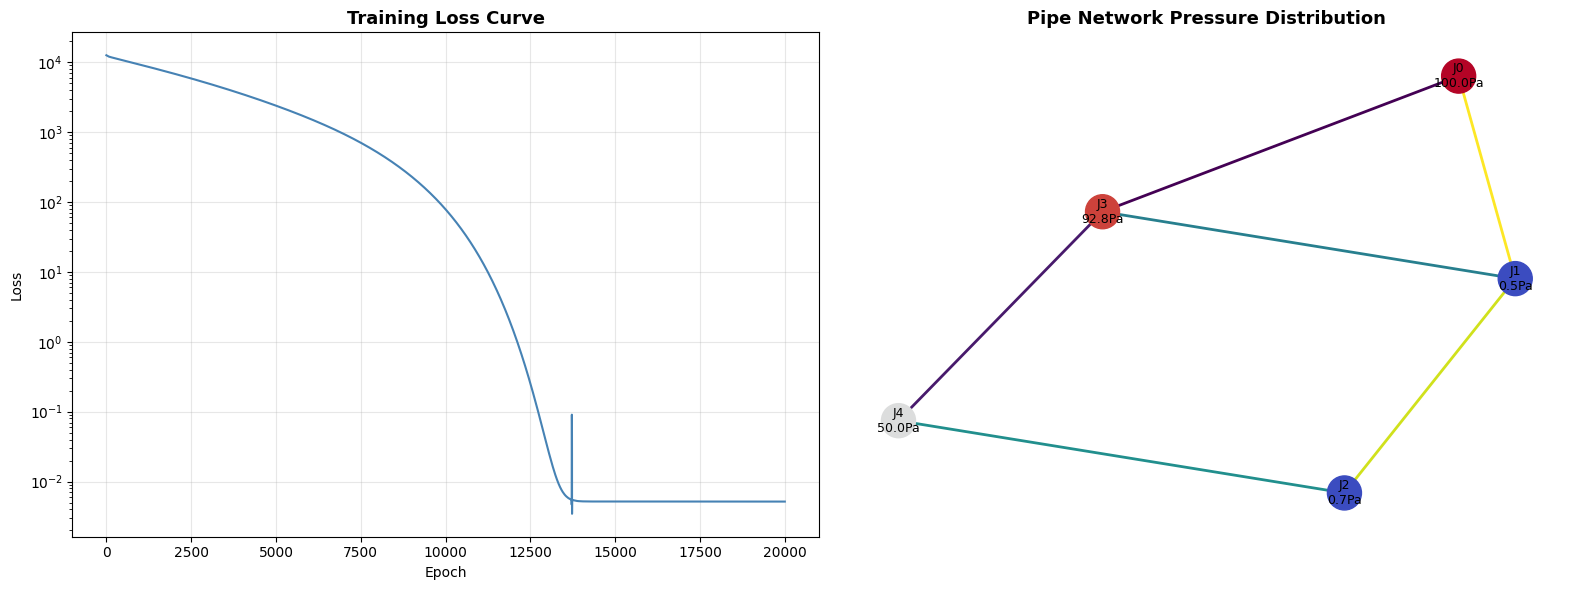

Saved: pinn_results.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#   Training loss curve  
axes[0].plot(loss_history, linewidth=1.5, color='steelblue')
axes[0].set_title('Training Loss Curve', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

#   Pipe network pressure distribution  
G = nx.Graph()
for i in range(connectivity.size(0)):
    G.add_edge(connectivity[i, 0].item(), connectivity[i, 1].item())

pos = nx.spring_layout(G, seed=42)
edge_colors = [
    abs(pressures_pred[connectivity[i, 0].item()] - pressures_pred[connectivity[i, 1].item()])
    for i in range(connectivity.size(0))
]

nx.draw_networkx_nodes(G, pos, ax=axes[1], node_color=pressures_pred,
                       cmap='coolwarm', node_size=600)
nx.draw_networkx_edges(G, pos, ax=axes[1], width=2,
                       edge_color=edge_colors, edge_cmap=plt.cm.viridis)
nx.draw_networkx_labels(G, pos, ax=axes[1],
                        labels={i: f'J{i}\n{pressures_pred[i]:.1f}Pa' for i in range(num_junctions)},
                        font_size=9)

axes[1].set_title('Pipe Network Pressure Distribution', fontsize=13, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('pinn_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: pinn_results.png")

## 8. Save Model

In [8]:
torch.save(model.state_dict(), 'pipe_network_pinn_model.pth')
print("Model saved: pipe_network_pinn_model.pth")

Model saved: pipe_network_pinn_model.pth
